In [2]:
!pip install tensorflow --quiet
!pip install tensorflow-hub --quiet
!pip install tensorflow-text --quiet
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [1]:
import os, re, random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')
pd.set_option('display.max_colwidth', None)
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

D0721 07:30:20.618428338    4312 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0721 07:30:20.618453134    4312 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0721 07:30:20.618456534    4312 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0721 07:30:20.618459291    4312 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0721 07:30:20.618461778    4312 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0721 07:30:20.618464343    4312 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0721 07:30:20.618467141    4312 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0721 07:30:20.

## Import Dataset

In [2]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [3]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

## Exploratory Data Analysis (EDA)

First, let's check if there are any mislabeled tweets inside the dataset. As we cannot manually inspect all tweets to see if the tweets have been correctly classifier, we are going to look for duplicate tweets and check that duplicates have been assigned to the same labels. 

In [4]:
duplicates = train[train.duplicated('text')]
duplicates.text.nunique()

69

There are 69 duplicate tweets inside the training dataset. We are going to iterate through these duplicate tweets to see if these duplicate tweets have unmatching labels. Unmatching labels would indicate that the tweet(s) has been mislabeled. We are going to store the index of these "problematic duplicates" inside a list and use it to iterature through these tweets so that we can re-assigned the correct labels after inspecting them.

In [8]:
problematic_duplicates = []

for i in range(duplicates.text.nunique()):
    duplicate_subset = train[train.text == duplicates.text.unique()[i]]
    if len(duplicate_subset) > 1 and duplicate_subset.target.nunique() == 2:
        problematic_duplicates.append(i)
        
print(problematic_duplicates)

[4, 7, 12, 15, 24, 26, 33, 34, 35, 36, 38, 39, 42, 44, 46, 51, 55]


In [5]:
train[train.text == duplicates.text.unique()[58]]

,id,keyword,location,text,target
6614,9470,terrorism,Jeddah_Saudi Arabia.,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,0
6616,9472,terrorism,Riyadh,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,1


Above is the 58th duplicate. We see that these tweets have unmatching labels despite their texts being identical. This tweet is not about an actual disaster, so we are going to correctly assign both tweets as not being about an actual disaster. This is going to look like this: 

In [6]:
train.target = np.where(train.text == duplicates.text.unique()[58], 0, train.target)
train[train.text == duplicates.text.unique()[58]]

,id,keyword,location,text,target
6614,9470,terrorism,Jeddah_Saudi Arabia.,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,0
6616,9472,terrorism,Riyadh,In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!,0


Let's repeat this task for all problematic duplicates after having identified the correct labels for each and every one of these problematic duplicates. We are going to store the correct labels inside a list and iterate through the problematic duplicates, assigning the correct labels one after the other.

In [9]:
target_list = [0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0]

for problematic_index in range(len(problematic_duplicates)): 
    train.target = np.where(train.text == duplicates.text.unique()[problematic_index], 
                            target_list[problematic_index], train.target)

## Preprocessing the Text

Before we use the text as input, we are going to perform some basic pre-processing. To identify the appropriate steps, let's look at some of the tweets.

In [42]:
random.seed(1048597)
sample_train = train.sample(frac = 1).head(5)
sample_train

,id,keyword,location,text,target
2182,3126,debris,NaN,#??? #?? #??? #??? MH370: Aircraft debris found on La Reunion is from missing Malaysia Airlines ... http://t.co/zxCORQ0A3a,1
5424,7742,panicking,NaN,you can stop panicking ?????? @ogtomd https://t.co/ZvRE6fFNyD,0
1415,2042,casualties,NaN,@CounterMoonbat @Voodoo_Ben I've heard we're still using Purple Hearts manufactured then bc of the # of casualties we expected.,1
6223,8883,smoke,PSA Nursing,@bre_morrow neither of them even smoke so I dk what was going on lol,0
226,321,annihilated,the own zone layer,day 1 of tryouts went good minus the fact I stopped quickly to get a short ball and Annihilated my toenail injury even more,0


In the randomly selected tweets above, we see that the tweets contain links (http://...), hashtags (#..), and mentions (@..). We are going to remove links entirely and keep hashtags and mentions in case they signal something.

In [43]:
def clean_text(dataframe):
    dataframe.text = dataframe.text.apply(lambda x: str.lower(x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'http\S+', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'#\S+', '', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'@\S+', '', x))
    # dataframe.text = dataframe.text.apply(lambda x: re.sub(r'\W+', ' ', x))
    dataframe.text = dataframe.text.apply(lambda x: re.sub(r'\d+', '', x))
    dataframe.text = dataframe.text.apply(lambda x: x.encode('utf8').decode('ascii', 'ignore'))
    return(dataframe)

In [44]:
sample_train = clean_text(sample_train)

In [45]:
sample_train

,id,keyword,location,text,target
2182,3126,debris,NaN,mh: aircraft debris found on la reunion is from missing malaysia airlines ...,1
5424,7742,panicking,NaN,you can stop panicking ??????,0
1415,2042,casualties,NaN,i've heard we're still using purple hearts manufactured then bc of the # of casualties we expected.,1
6223,8883,smoke,PSA Nursing,neither of them even smoke so i dk what was going on lol,0
226,321,annihilated,the own zone layer,day of tryouts went good minus the fact i stopped quickly to get a short ball and annihilated my toenail injury even more,0


In [46]:
clean_train = clean_text(train)

In [47]:
clean_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this may allah forgive us all,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are being notified by officers. no other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,", people receive evacuation orders in california",1
4,7,NaN,NaN,just got sent this photo from ruby as smoke from pours into a school,1


## Balance the Training Dataset

In [19]:
clean_train.target.value_counts()

target
0    4358
1    3255
Name: count, dtype: int64

In [48]:
clean_train_balanced = clean_train.groupby('target').sample(3000)

In [49]:
train_df, val_df = np.split(clean_train.sample(frac = 1), [int(0.8 * len(clean_train))])

In [50]:
print('Number of observations inside the training dataset: {}'.format(len(train_df)))
print('Number of observations inside the validation dataset: {}'.format(len(val_df)))

Number of observations inside the training dataset: 6090
Number of observations inside the validation dataset: 1523


## Define and Train Model - First Model

In [24]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [25]:
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

In [26]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string)
encoder_input = bert_preprocess(text_input)
encoder_output = bert_encoder(encoder_input)

l = tf.keras.layers.Dropout(0.3)(encoder_output['pooled_output'])
l = tf.keras.layers.Dense(16, activation = 'relu')(l)
l = tf.keras.layers.Dense(1, activation = 'sigmoid')(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [27]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                  patience = 2)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'model/best_performed_model.ckpt',
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

In [29]:
history = model.fit(train_df.text,
                    train_df.target,
                    validation_data = (val_df.text, val_df.target),
                    epochs = 30,
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
191/191 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.6411
Epoch 1: val_loss improved from inf to 0.55464, saving model to model/best_performed_model.ckpt
191/191 [==============================] - 412s 2s/step - loss: 0.6322 - accuracy: 0.6411 - val_loss: 0.5546 - val_accuracy: 0.7150
Epoch 2/30
191/191 [==============================] - ETA: 0s - loss: 0.5703 - accuracy: 0.7182
Epoch 2: val_loss improved from 0.55464 to 0.54732, saving model to model/best_performed_model.ckpt
191/191 [==============================] - 381s 2s/step - loss: 0.5703 - accuracy: 0.7182 - val_loss: 0.5473 - val_accuracy: 0.7413
Epoch 3/30
191/191 [==============================] - ETA: 0s - loss: 0.5638 - accuracy: 0.7176
Epoch 3: val_loss improved from 0.54732 to 0.52895, saving model to model/best_performed_model.ckpt
191/191 [==============================] - 383s 2s/step - loss: 0.5638 - accuracy: 0.7176 - val_loss: 0.5289 - val_accuracy: 0.7544
Epoch 4/30
191/191 [

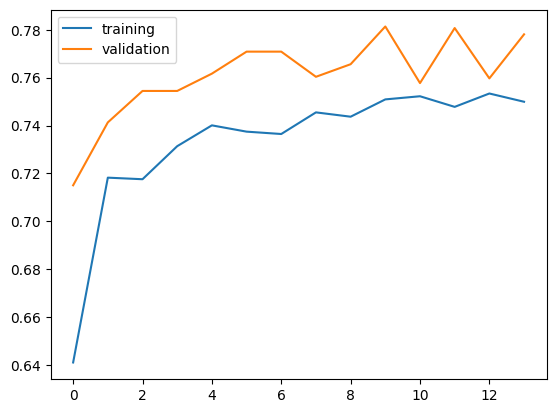

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

This bert-base-uncased model returned a validation accuracy of 0.78, and the plot of both training and validation accuracy did not show evidence of over-fitting. As we are hoping to achieve validation accuracy of 80% or higher, we are going to move onto a new model and attempt to achieve better performance.

In [32]:
## Define and Train Model - Second Model

In [33]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [34]:
bert_preprocess = hub.KerasLayer(tfhub_handle_preprocess)
bert_encoder = hub.KerasLayer(tfhub_handle_encoder)

In [35]:
train_df, val_df = np.split(clean_train.sample(frac = 1), [int(0.9 * len(clean_train))])

In [36]:
print('Number of observations inside the training dataset: {}'.format(len(train_df)))
print('Number of observations inside the validation dataset: {}'.format(len(val_df)))

Number of observations inside the training dataset: 6851
Number of observations inside the validation dataset: 762


In [40]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string)
encoder_input = bert_preprocess(text_input)
encoder_output = bert_encoder(encoder_input)

l = tf.keras.layers.Dense(32, activation = 'relu')(encoder_output['pooled_output'])
l = tf.keras.layers.Dropout(0.3)(l)
l = tf.keras.layers.Dense(1, activation = 'sigmoid')(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

And we are going to increase the learning rate of the model as the model was very slow at learning. We are going to set the learning rate to 0.005 and see how things go.

In [41]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [42]:
history = model.fit(train_df.text,
                    train_df.target,
                    validation_data = (val_df.text, val_df.target),
                    epochs = 30,
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
214/215 [============================>.] - ETA: 0s - loss: 0.5287 - accuracy: 0.7496
Epoch 1: val_loss did not improve from 0.45877
215/215 [==============================] - 45s 203ms/step - loss: 0.5286 - accuracy: 0.7497 - val_loss: 0.4845 - val_accuracy: 0.7861
Epoch 2/30
214/215 [============================>.] - ETA: 0s - loss: 0.4894 - accuracy: 0.7764
Epoch 2: val_loss did not improve from 0.45877
215/215 [==============================] - 41s 193ms/step - loss: 0.4896 - accuracy: 0.7764 - val_loss: 0.4805 - val_accuracy: 0.7795
Epoch 3/30
214/215 [============================>.] - ETA: 0s - loss: 0.4785 - accuracy: 0.7817
Epoch 3: val_loss did not improve from 0.45877
215/215 [==============================] - 42s 196ms/step - loss: 0.4784 - accuracy: 0.7818 - val_loss: 0.4869 - val_accuracy: 0.7795
Epoch 4/30
214/215 [============================>.] - ETA: 0s - loss: 0.4748 - accuracy: 0.7886
Epoch 4: val_loss improved from 0.45877 to 0.45581, saving model to model

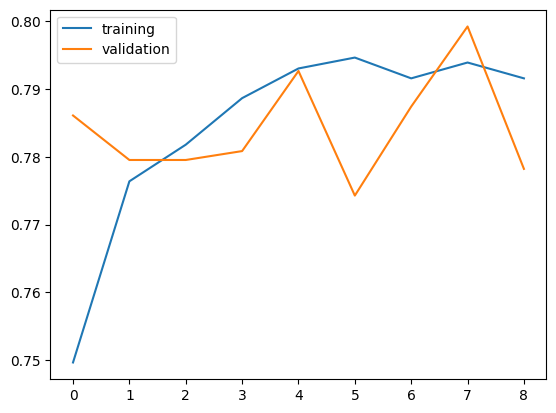

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

This smallBERT model returned a validation accuracy of 0.78, and the plot of both training and validation accuracy did not show evidence of over-fitting. However, fluctuating validation accuracy suggests that the size of the validation dataset may be too small. We are going to go back to using 80% and 20% of all observations as our training and validation datasets. For the same reason as the first model, we are going to move onto a new model and attempt to achieve better performance.

## Define and Train Model - Third Model

In [66]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [68]:
train_df, val_df = np.split(clean_train.sample(frac = 1), [int(0.8 * len(clean_train))])

In [125]:
VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token = "<OOV>")
tokenizer.fit_on_texts(train_df.text)
word_index = tokenizer.word_index

In [126]:
train_sequences = tokenizer.texts_to_sequences(train_df.text)
train_padded = pad_sequences(train_sequences,
                             maxlen= 50,
                             padding= 'post',
                             truncating= 'post')

In [127]:
val_sequences = tokenizer.texts_to_sequences(val_df.text)
val_padded = pad_sequences(val_sequences,
                           maxlen= 50,
                           padding= 'post',
                           truncating= 'post')

In [128]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(VOCAB_SIZE, 16))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [129]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [130]:
history = model.fit(train_padded,
                    train_df.target,
                    validation_data = (val_padded, val_df.target),
                    epochs = 30,
                    callbacks = [early_stopping, model_checkpoint_callback])

Epoch 1/30
190/191 [============================>.] - ETA: 0s - loss: 0.6633 - accuracy: 0.5836
Epoch 1: val_loss did not improve from 0.45686
191/191 [==============================] - 9s 26ms/step - loss: 0.6632 - accuracy: 0.5839 - val_loss: 0.5865 - val_accuracy: 0.7433
Epoch 2/30
190/191 [============================>.] - ETA: 0s - loss: 0.5145 - accuracy: 0.7847
Epoch 2: val_loss did not improve from 0.45686
191/191 [==============================] - 4s 21ms/step - loss: 0.5147 - accuracy: 0.7846 - val_loss: 0.4896 - val_accuracy: 0.7761
Epoch 3/30
190/191 [============================>.] - ETA: 0s - loss: 0.4331 - accuracy: 0.8202
Epoch 3: val_loss did not improve from 0.45686
191/191 [==============================] - 4s 21ms/step - loss: 0.4328 - accuracy: 0.8204 - val_loss: 0.4694 - val_accuracy: 0.7853
Epoch 4/30
190/191 [============================>.] - ETA: 0s - loss: 0.3919 - accuracy: 0.8380
Epoch 4: val_loss did not improve from 0.45686
191/191 [=======================